In [305]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from jcopml.pipeline import num_pipe
from jcopml.feature_importance import mean_score_decrease

In [2]:
df = pd.read_csv("Diabetes.csv")
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [7]:
X = df.drop(columns="Outcome")
y = df.Outcome

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=13)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

preprocessor = ColumnTransformer([
    ("numeric", num_pipe(), X.columns)
])

pipeline = Pipeline([
    ("prep", preprocessor),
    ("algo", RandomForestClassifier(n_jobs=-1, random_state=13))
])

model = GridSearchCV(pipeline, gsp.rf_params, n_jobs=-1, verbose=1, cv=3)
model.fit(X_train, y_train)

model.score(X_train, y_train), model.score(X_test, y_test)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:  1.6min finished


(0.9071661237785016, 0.7727272727272727)

,feature,importance,stdev
1,Glucose,0.162866,0.014123
7,Age,0.081433,0.005735
5,BMI,0.078827,0.009362
6,DiabetesPedigreeFunction,0.058306,0.005293
0,Pregnancies,0.036156,0.002802
4,Insulin,0.034202,0.005150
2,BloodPressure,0.032248,0.002802
3,SkinThickness,0.020847,0.002606


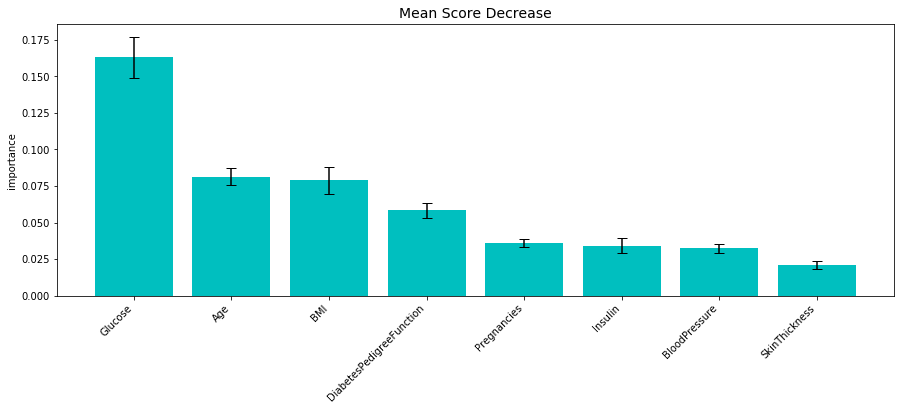

In [306]:
mean_score_decrease(X_train=X_train, y_train=y_train, model=model, plot=True)

In [19]:
import tkinter as tk
import re

In [309]:
class gui(tk.Tk):
    def __init__(self):
        tk.Tk.__init__(self)

        self.generateWindow()

        self.field = {}
        self.text = {}
        self.row = 1

        for field in X.columns:
            self.generateInput(field)
        
        self.generateButton()
        self.generateTextResult()


    def generateWindow(self):
        self.title("Diabetes Detector")
        self.resizable(0, 0)
        self.configure(bg="white")
        
        w_width = 800
        w_height = 600

        s_width = self.winfo_screenwidth()
        s_height = self.winfo_screenheight()

        self.geometry("{}x{}+{}+{}".format(w_width, w_height, s_width//2 - w_width//2, s_height//2 - w_height//2))

        self.banner = tk.Label(text="DIABETES DETECTOR", bg="white", font=("Courir", 30))
        self.banner.grid(row=0, column=0, columnspan=2, padx=5, pady=30)
        self.grid_rowconfigure(0, weight=1)
        self.grid_columnconfigure(0, weight=1)



    def naming(self, key):
        return " ".join(re.findall('[A-Z][^A-Z]*', key))


    def generateInput(self, key):
        text = tk.Label(text=self.naming(key), bg="white", font=50)
        text.grid(row=self.row, column=0, padx=5)

        field = tk.Entry(highlightthickness=2, bd=0, font=50, borderwidth=5, relief=tk.FLAT)
        field.grid(row=self.row, column=1)
        field.config(highlightbackground="#bbb", highlightcolor="#0034ad")

        self.grid_rowconfigure(self.row, weight=1)
        self.grid_columnconfigure(0, weight=1)
        self.grid_columnconfigure(1, weight=1)

        self.text[key] = text
        self.field[key] = field
        self.row += 1



    def generateButton(self):
        self.predict = tk.Button(text="Predict", font=50, bg="#bbb", width="25", highlightthickness=2, bd=0, command=self.predict)
        self.predict.grid(row=self.row+1, column=0, columnspan=2, padx=5, pady=30)
        self.grid_rowconfigure(0, weight=1)
        self.grid_columnconfigure(0, weight=1)


    
    def generateTextResult(self):
        self.result = tk.Label(text="", bg="white", font=("Courir", 20, "bold"))
        self.result.grid(row=self.row+2, column=0, columnspan=2, padx=5, pady=30)
        self.grid_rowconfigure(0, weight=1)
        self.grid_columnconfigure(0, weight=1)

    

    def predict(self):
        data = []
        for key in self.field.keys():
            field = self.field[key]
            result = field.get()

            if field.index("end") == 0:
                self.result["text"] = "{} required".format(self.naming(key))
                return
            
            try:
                data.append(float(result))
            except:
                self.result["text"] = "{} must be numeric".format(self.naming(key))
                return

        
        is_detected = model.predict(pd.DataFrame([data], columns=X.columns))[0]
        if(is_detected):
            self.result["text"] = "Diabetes Detected"
        else:
            self.result["text"] = "Diabetes is Not Detected"

In [311]:
main = gui()
main.mainloop()